In [1]:
import os
import numpy as np
import pandas as pd
import time

batch_size = 32

# Fetch Dataset

Using 5559 files for training.
Using 1390 files for validation.
torch.Size([3, 128, 256])


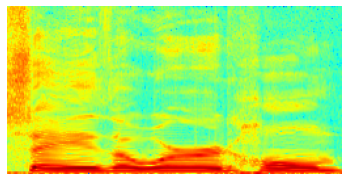

torch.Size([3, 128, 256])


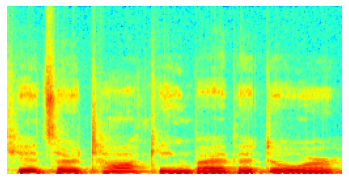

torch.Size([3, 128, 256])


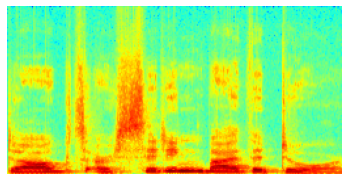

torch.Size([3, 128, 256])


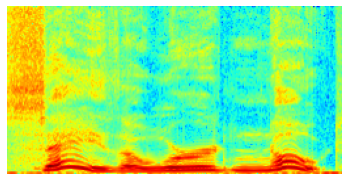

In [5]:
%run /data/emo/notebooks/source/pipeline/generator.ipynb
train_ds, valid_ds = Generator.generate(TrinairCombined, Spectrogram).to_dataset()

train_loader = utils.DataLoader(train_ds, batch_size=batch_size, shuffle=True , num_workers=4)
valid_loader = utils.DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=4)

print("Using", len(train_ds), "files for training.")
print("Using", len(valid_ds), "files for validation.")

print(train_ds.head())

for i in range(4):
    print(train_ds[i][0].shape)
    plt.imshow(train_ds[i][0].permute(1, 2, 0))
    plt.axis('off'); 
    plt.show()

# Create Model

In [6]:
import torch
import torchmetrics
import torch.nn as nn
import torch.nn.functional as fn
# from torchsummary import summary
import pytorch_lightning as pl

cnn_output = 8

class Convolutional(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.configure_metrics()
        self.loss_func = nn.CrossEntropyLoss()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(4, 4)
        self.pool3 = nn.MaxPool2d(4, 4)
        self.fc1 = nn.Linear(64*3*7, 64)
        self.fc2 = nn.Linear(64, cnn_output)

    def forward(self, x):
        x = self.pool1(fn.relu(self.conv1(x)))
        x = self.pool2(fn.relu(self.conv2(x)))
        x = self.pool3(fn.relu(self.conv3(x)))
        x = x.view(-1, 64*3*7) # Flatten layer
        x = fn.relu(self.fc1(x))
        x = fn.log_softmax(self.fc2(x), dim=1)
        return x
    
    def configure_metrics(self):
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.valid_precision = torchmetrics.Precision(num_classes=cnn_output)
        self.valid_recall = torchmetrics.Recall(num_classes=cnn_output)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.001, weight_decay=0.01)
#         optimizer = torch.optim.Adam(self.parameters())
        return optimizer
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        output = self(x)
        loss = self.loss_func(output, y)
        self.valid_precision(output, y)
        self.valid_recall(output, y)
        self.valid_acc(output, y)
        self.log("precision", self.valid_precision, on_step=False, on_epoch=True, logger=True)
        self.log("recall", self.valid_recall, on_step=False, on_epoch=True, logger=True)
        self.log('val_acc', self.valid_acc, on_step=False, on_epoch=True, logger=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True, logger=True)
        
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        output = self(x)
        loss = self.loss_func(output, y)
        self.train_acc(output, y)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, logger=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True, logger=True)
        return loss

network = Convolutional()
# summary(network, (3, 128, 256))

## Callback function
Should only contain logging and visualization logic

In [7]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(monitor="val_loss")

In [8]:
from pytorch_lightning.callbacks import Callback

# TODO: Feature map from filterd images https://www.kaggle.com/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn

class ConvolutionalCallback(Callback):
    def __init__(self):
        self.conv_layers = []
    
#     def on_init_start(self, trainer):
#         """Gets executed before the trainer fit, predicts, ect.
#         """
# #         counter = 0
#         model_weights = []
#         model_children = list(trainer.lightning_module().children())
        
#         for i in range(len(model_children)):
#             if type(model_children[i]) == nn.Conv2d:
# #                 counter += 1
#                 model_weights.append(model_children[i].weight)
#                 self.conv_layers.append(model_children[i])
#             elif type(model_children[i]) == nn.Sequential:
#                 for j in range(len(model_children[i])):
#                     for child in model_children[i][j].children():
#                         if type(child) == nn.Conv2d:
# #                             counter += 1
#                             self.model_weights.append(child.weight)
#                             self.conv_layers.append(child)
#         print(f"Total convolutional layers: {counter}")

#         for weight, conv in zip(model_weights, self.conv_layers):
#             print(f"CONV: {conv} => WEIGHT SHAPE: {weight.shape}")
    
    def on_fit_start(self, trainer, pl_module):
        """Callback function that gets executed before the fit starts

        Parameters
        ----------
        trainer : pl.Trainer
            The trainer of the CNN module (pl_module)
        pl_module : pl.LightningModule
            The model we want to use to retrieve information
        """
        print("Starting to fit trainer!")
        
        # Created a instance of the manual logger
        self.writer = pl_module.logger.experiment
        
        # Connect the hooks to the CNN
        pl_module.fc1.register_forward_hook(self.activation_hook)
        pl_module.fc2.register_forward_hook(self.activation_hook)

    def activation_hook(self, inst, inp, out):
        """Run activation hook

        Parameters
        ----------
        inst : torch.nn.Module
            The layer we want to attach the hook to.
        inp : torch.Tensor
            The input to the `forward` method.
        out : torch.Tensor
            The output of the `forward` method.
        """
        # Create histogram of layer weights
        self.writer.add_histogram(repr(inst), out)

        # Create a grid with filterd images
        img_grid = torchvision.utils.make_grid(inp[0])
        self.writer.add_image('Forward Input images', img_grid)

        # Create a grid with filterd images
        img_grid = torchvision.utils.make_grid(out)
        self.writer.add_image('Forward Output images', img_grid)
    
#     def on_train_batch_start(self, trainer, pl_module, batch, batch_idx):
#         """Start before the training batch
#         """
#         images, labels = batch
#         # Get single image
#         image = images[0, :, :, :]
#         # Convert to numpy array
#         image = image.mean(dim=0)
#         image = image.numpy()
        
#         # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#         self.writer.add_image('Image', image)

#         # unsqueeze image to add a batch dimension
#         image = image.unsqueeze(0)
        
#         self.vis_feature_map('Feature map', image):
    
#     def vis_feature_map(self, image):
#         """Visualize feature map of given image
        
#         Parameters
#         ----------
#         image : numpy.ndarray
#             ndarray of the image
#         """
#         # pass the image through the first layers
#         outputs = [self.conv_layers[0](image)]
#         for i in range(1, len(conv_layers)):
#             # pass the results for the last layer to the next layer
#             outputs.append(self.conv_layers[i](outputs[-1]))
        
#         for num_layer in range(len(outputs)):
#             fig = plt.figure(figsize=(25, 25))
#             # Take the first image of the batch [0, :, :, :]
#             layer_viz = outputs[num_layer][0, :, :, :]
#             layer_viz = layer_viz.data
#             print(layer_viz.size())

#             amount = 6
#             for i, filter in enumerate(layer_viz):
#                 if i == amount:
#                     break
#                 fig.subplot(4, 4, i+1)
#                 fig.imshow(filter, cmap='gray')
#                 fig.axis('off')
#             print(f'Saving layer {num_layer} feature maps ...')
#             self.writer.add_figure(fig)
        

# Train Model

In [9]:
n_epochs = 5
# ssh -L 6006:127.0.0.1:6006 18082920@datascience.hhs.nl
# tensorboard --logdir ./tb_logs
logger = pl.loggers.TensorBoardLogger('tb_logs', name='convolutional_vis')
trainer = pl.Trainer(
    max_epochs=n_epochs, 
    weights_summary=None, 
    logger=logger, 
    callbacks=[ConvolutionalCallback(), checkpoint_callback]
)
trainer.fit(network, train_loader, valid_loader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Starting to fit trainer!


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1303: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Load model

In [10]:
model = network.load_from_checkpoint(checkpoint_callback.best_model_path)

In [ ]:
print(model)

# Save the conv layers weights
model_weights = []
# Save the conv layers
conv_layers = []

# Get children of model
model_children = list(model.children())

In [ ]:
counter = 0

for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

for weight, conv in zip(model_weights, conv_layers):
    print(f"CONV: {conv} => WEIGHT SHAPE: {weight.shape}")

### Visualizing Convolutional Layer Filters

In [ ]:
plt.figure(figsize=(15,12))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
# Get single image from dataloader
image = images[0, :, :, :]
# Convert to numpy array
img = image.mean(dim=0)
# img = img / 2 + 0.5
img = img.numpy()
print(type(img))
print(img.shape)

In [ ]:
import cv2 as cv

# img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(images[i].permute(1, 2, 0))
plt.title("Original spectogram", fontsize=18)
plt.ylabel("frequency (Htz)", fontsize=14)
plt.xlabel("Duration (ms)", fontsize=14)
plt.show()

print(type(image))
print(image.size())
# unsqueeze image to add a batch dimension
image = image.unsqueeze(0)
print(image.size())

In [ ]:
# pass the image through the first layers
results = [conv_layers[0](image)]
for i in range(1, len(conv_layers)):
    # pass the results for the last layer to the next layer
    results.append(conv_layers[i](results[-1]))

outputs = results

### Visualizing the Feature Maps

In [ ]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(20, 20))
    # Take the first image of the batch [0, :, :, :]
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    
    amount = 9
    for i, filter in enumerate(layer_viz):
        if i == amount:
            break
        plt.subplot(3, 3, i+1)
        plt.imshow(filter.permute(0, 1), cmap='gray', interpolation='nearest')
#         plt.axis('off')
        plt.title(f"Feature map layer: {num_layer} - image: {i}", fontsize=18)
        plt.ylabel("frequency (Htz)", fontsize=14)
        plt.xlabel("Duration (ms)", fontsize=14)
    print(f'Saving layer {num_layer} feature maps ...')
    plt.savefig(f'./layer_{num_layer}.png')
    plt.show()
    plt.close()